In [6]:
from django_pandas.io import read_frame
import pandas as pd
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

import os
os.environ['DJANGO_SETTINGS_MODULE'] = 'winesurvey.settings'
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import django
django.setup()

from survey.models import WineItem, SurveyQuestionResponse, SurveyABTestInstance

wine_data = pd.read_csv('data/wineitem_0519_0953.csv')
ab_data = pd.read_csv('data/surveyabtestinstance_0519_1758.csv')
survey_data = pd.read_csv('data/surveyquestionresponse_0519_1758.csv')

In [7]:
wine_data = wine_data[wine_data['price'] < 100]
valid_wines = wine_data['item key'].tolist()

In [33]:
from elosports.elo import Elo
eloLeague = Elo(k = 20, homefield=0)

for _, w in wine_data.iterrows():
    eloLeague.addPlayer(w['item key'])
    
for _, ab in ab_data.iterrows():
    if ab['winner_id'] in valid_wines and ab['loser_id'] in valid_wines:
        eloLeague.gameOver(winner=ab['winner_id'], loser=ab['loser_id'], winnerHome=False)

elo = pd.DataFrame(columns = ['item_key', 'elo'])
for team in eloLeague.ratingDict.keys():
    row = {'item_key': team, 'elo': eloLeague.ratingDict[team]}
    elo = elo.append(row, ignore_index=True)
elo = elo.sort_values(by='elo', ascending=False)

data = elo.join(wine_data.set_index('item key'), on='item_key')
data = data.join(ab_data['winner_id'].value_counts(), on='item_key').rename(columns={'winner_id': 'wins'})
data = data.join(ab_data['loser_id'].value_counts(), on='item_key').rename(columns={'loser_id': 'losses'})

data = pd.get_dummies(data, columns=['label type','region','varietal','vintage','origin'])

In [29]:
data

,item_key,elo,name,description,price,bottle image url,label type,closure type,country,region,...,story,user rating,sale price,original url,tasting notes,winc product id,winc product code,wine product id,wins,losses
95,wine531884,1625.583373,2016 Tenuta di Nozzole Chianti Classico Riserva,"Cherry and violet aromas, persistent and round...",19.99,"https://www.wine.com/product/images/w_480,h_60...",TR,NaN,NaN,Chianti Classico,...,"Cherry and violet aromas, persistent and round...",NaN,NaN,NaN,NaN,NaN,NaN,531884.0,20.0,3.0
141,wine566934,1604.273432,2016 Shannon Reserve Home Ranch Reserve Cabern...,"A warm inland area just north of Napa Valley, ...",19.99,"https://www.wine.com/product/images/w_480,h_60...",TR,NaN,NaN,Lake County,...,"A warm inland area just north of Napa Valley, ...",NaN,NaN,NaN,NaN,NaN,NaN,566934.0,23.0,7.0
159,wine526431,1602.285456,2018 Patient Cottat Sancerre Anciennes Vignes,Lemon with golden-green reflections. Complex a...,27.99,"https://www.wine.com/product/images/w_480,h_60...",MO,NaN,NaN,Sancerre,...,Lemon with golden-green reflections. Complex a...,NaN,NaN,NaN,NaN,NaN,NaN,526431.0,20.0,7.0
103,wine556950,1600.428363,2017 Joel Gott Blend No. 815 Cabernet Sauvignon,"Joel Gott, the founder of Joel Gott Wines, is ...",16.99,"https://www.wine.com/product/images/w_480,h_60...",TR,NaN,NaN,California,...,"Joel Gott, the founder of Joel Gott Wines, is ...",NaN,NaN,NaN,NaN,NaN,NaN,556950.0,15.0,2.0
114,wine526236,1599.979514,2018 Oberon Cabernet Sauvignon,With a kiss of Petite Verdot and a dash of Zin...,21.99,"https://www.wine.com/product/images/w_480,h_60...",MO,NaN,NaN,Napa Valley,...,With a kiss of Petite Verdot and a dash of Zin...,NaN,NaN,NaN,NaN,NaN,NaN,526236.0,23.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,wine525906,1410.622391,2018 Vanderpump Rose,"Pale rose, peach color. Elegant nose with deli...",18.99,"https://www.wine.com/product/images/w_480,h_60...",WH,NaN,NaN,Cotes de Provence,...,"Pale rose, peach color. Elegant nose with deli...",NaN,NaN,NaN,NaN,NaN,NaN,525906.0,7.0,20.0
71,wine533848,1386.435385,2018 Kris Pinot Grigio,"Recommended with salad, roast vegetables, riso...",12.99,"https://www.wine.com/product/images/w_480,h_60...",WH,NaN,NaN,Friuli-Venezia Giulia,...,"Recommended with salad, roast vegetables, riso...",NaN,NaN,NaN,NaN,NaN,NaN,533848.0,7.0,22.0
44,winc11749,1378.480172,2015 Compartés x WINC Sparkling Red Blend,Introducing our collaboration with Compartés: ...,32.99,https://d207gb2bfvg73.cloudfront.net/1601981/h...,WH,CO,United States,Santa Barbara County,...,Jonathan Grahm knows a whole lot about the swe...,3.5,24.99,NaN,NaN,11749.0,1601981.0,NaN,2.0,18.0
134,wine527517,1368.954337,2015 Jordan Cabernet Sauvignon,Pure elegance in a glass. Aromas of black cher...,64.99,"https://www.wine.com/product/images/w_480,h_60...",TR,NaN,NaN,Alexander Valley,...,Pure elegance in a glass. Aromas of black cher...,NaN,NaN,NaN,NaN,NaN,NaN,527517.0,8.0,25.0


## Price

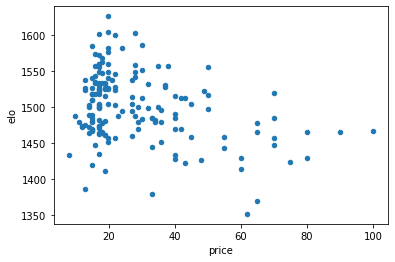

In [24]:
elo.plot.scatter(x='price', y='elo')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e3f5c50>]],
      dtype=object)

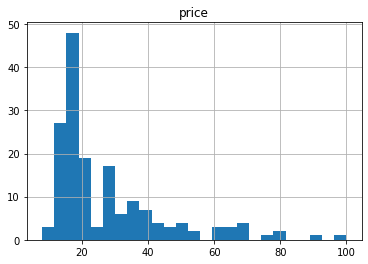

In [27]:
elo.hist('price', bins=25)

,item_key,elo,name,description,price,bottle image url,closure type,country,wine type,point score,...,"origin_San Benito County, California",origin_Sangiovese,"origin_Santa Barbara County, California",origin_Sauvignon Blanc,"origin_Sonoma, California","origin_Sta. Rita Hills, California",origin_Tempranillo,origin_Tuscan Blends,"origin_Vino de Espana, Spain",origin_Zinfandel
95,wine531884,1625.583373,2016 Tenuta di Nozzole Chianti Classico Riserva,"Cherry and violet aromas, persistent and round...",19.99,"https://www.wine.com/product/images/w_480,h_60...",NaN,NaN,R,NaN,...,0,1,0,0,0,0,0,0,0,0
141,wine566934,1604.273432,2016 Shannon Reserve Home Ranch Reserve Cabern...,"A warm inland area just north of Napa Valley, ...",19.99,"https://www.wine.com/product/images/w_480,h_60...",NaN,NaN,R,NaN,...,0,0,0,0,0,0,0,0,0,0
159,wine526431,1602.285456,2018 Patient Cottat Sancerre Anciennes Vignes,Lemon with golden-green reflections. Complex a...,27.99,"https://www.wine.com/product/images/w_480,h_60...",NaN,NaN,W,NaN,...,0,0,0,1,0,0,0,0,0,0
103,wine556950,1600.428363,2017 Joel Gott Blend No. 815 Cabernet Sauvignon,"Joel Gott, the founder of Joel Gott Wines, is ...",16.99,"https://www.wine.com/product/images/w_480,h_60...",NaN,NaN,R,NaN,...,0,0,0,0,0,0,0,0,0,0
114,wine526236,1599.979514,2018 Oberon Cabernet Sauvignon,With a kiss of Petite Verdot and a dash of Zin...,21.99,"https://www.wine.com/product/images/w_480,h_60...",NaN,NaN,R,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,wine525906,1410.622391,2018 Vanderpump Rose,"Pale rose, peach color. Elegant nose with deli...",18.99,"https://www.wine.com/product/images/w_480,h_60...",NaN,NaN,Ro,NaN,...,0,0,0,0,0,0,0,0,0,0
71,wine533848,1386.435385,2018 Kris Pinot Grigio,"Recommended with salad, roast vegetables, riso...",12.99,"https://www.wine.com/product/images/w_480,h_60...",NaN,NaN,W,NaN,...,0,0,0,0,0,0,0,0,0,0
44,winc11749,1378.480172,2015 Compartés x WINC Sparkling Red Blend,Introducing our collaboration with Compartés: ...,32.99,https://d207gb2bfvg73.cloudfront.net/1601981/h...,CO,United States,R,NaN,...,0,0,1,0,0,0,0,0,0,0
134,wine527517,1368.954337,2015 Jordan Cabernet Sauvignon,Pure elegance in a glass. Aromas of black cher...,64.99,"https://www.wine.com/product/images/w_480,h_60...",NaN,NaN,R,NaN,...,0,0,0,0,0,0,0,0,0,0


In [15]:
elo.head(5)
#elo.groupby('varietal').mean()
pearsonr(elo['price'], elo['elo'])

(-0.3452462190761073, 4.892449558203516e-06)

wine601963    23
wine526236    23
wine566934    23
winc12165     21
winc10999     21
              ..
wine578229     3
winc11749      2
wine590147     2
wine202479     2
wine134096     1
Name: winner_id, Length: 174, dtype: int64

In [ ]:
qs = SurveyQuestionResponse.objects.all()
df = read_frame(qs)

df.pivot(index='survey_response',columns='survey_question',values='answer')
